<body>
    <font size="2">Florian Schnabel, 11807470, SS 2023</font><br />
</body>

(sec:Ex1)=
# Exercise 1 - Heat Conduction with multiple layers and variable properties

This script aims to calculate the temperature field across a multi-layered building component. The building component can have any number of layers with varying properties. In addition to that,
the thickness of the layer and the number of finite volumes used to discretise
the domain can vary. Such a multi-layered building component is shown in {numref}`fig:multilayComp`.

```{figure} ./Figures/BuildingComponent.png
---
width: 350px
name: fig:multilayComp
---
Multi-layered building component and discretisation requirements [excersise Description]
```

 To allow a numerical solution of the problem, the partial differential equation for heat conduction must be discretised. The equation for heat conduction is shown in {eq}`heatflow` {cite}`walther2021`:
 
$$
\rho \cdot c \cdot \frac{dT}{dt} = \nabla (\lambda \nabla T) 
$$ (heatflow)

reduced to one dimension:

$$ \rho \cdot c \cdot \frac{dT}{dt} =  \frac{d}{dx}(\lambda \frac{dT}{dx}) $$


## Space discretisation

The discretisation is done using the finite volume method and a representation as RC-Networks. Each cell is represented by a resistance and the conductivity to the neighbouring cells. The conductivity between Interrior cells is calculated as follows (for simplicity, the surface resistance between layers is neglected. $ R_{ci} =0 $ ) {cite}`hagenthoft2001`:

$$K_{i-0.5} = \frac{1}{\frac{0.5 \Delta x_{i-1}}{\lambda_{i-1}} + R_{ci} + \frac{0.5 \Delta x_{i}}{\lambda_{i}}} $$ (conductivityInterior)

For a cell inside a layer ($\lambda_{i-1} = \lambda_{i} = \lambda_{i+1}$ and $\Delta x_{i-1} = \Delta x_{i} = \Delta x_{i+1}$) {eq}`conductivityInterior` collapses to {eq}`conductivityInteriorcoll`:

$$ K_{i-0.5} = K_{i+0.5} = \frac{\lambda_{i}}{\Delta x_{i}} $$ (conductivityInteriorcoll)


And for Cells at the boundary:

$$ K_{BC,1} = K_{0.5} = \frac{1}{R_{s,1} + \frac{0.5 \Delta x_{1}}{\lambda_{1}}} $$

## Time Integration
Using the explicit euler sheme the next Timestep can be calculated as follows:

 
$$
\begin{aligned}
    &\text{for cells at the left boundary:}& &T_1^{n+1} = T_1^n+F_{o,1}^* \cdot (K_{BC,1} \cdot   T_{BC}^n  - (K_{BC,l}+K_{2}) \cdot   T_{1}^n + K_{2} \cdot   T_{2}^n)& \\
    &\text{for interior cells:}& &T_i^{n+1} = T_1^n+F_{o,i}^* \cdot (K_{i-1} \cdot   T_{i-1}^n  - (K_{i-1}+K_{i+1}) \cdot   T_{i}^n + K_{i+1} \cdot   T_{i+1}^n)& \\
    &\text{for cells at the right boundary:}& &T_j^{n+1} = T_j^n+F_{o,j}^* \cdot (K_{j-1} \cdot   T_{j-1}^n  - (K_{j-1}+K_{BC,2}) \cdot   T_{j}^n + K_{BC,2} \cdot   T_{BC,2}^n)& \\
\end{aligned}
$$


or generally written (based on {cite}`walther2021`):

$$ T^{n+1} = T^n + F_{o}^* \cdot K \cdot T^n $$ (timeint)



With the conductivity matrix $ K $:



$$ K = \left [ 
\begin{array}{ccccccc}
    0 & 0 & 0 & 0 & (...) & 0 & 0 & 0  & 0\\
    K_{BC,1} & -(K_{BC,1} + K_w) & K_w & 0 & (...) & 0 & 0 & 0 & 0\\
    0 & K_e & -(K_e + K_w) & K_w & (...) & 0 & 0  & 0 & 0\\
    (...) & (...) & (...) & (...) & (...) & (...) & (...)  & (...) & (...)\\
    0 & 0 & 0 & 0 &(...) & K_{e} & -(K_e + K_w) & K_w & 0 \\
    0 & 0 & 0 & 0 &(...) & 0 & K_{e} & -(K_e + K_{BC,2}) & K_{BC,2} \\
    0 & 0 & 0 & 0 &(...) & 0 & 0 & 0 & 0 \\
\end{array}
\right] $$

and the adapted "resistance" matrix $F_{o}^*$ (example for layers a,b,c):

$$ F_{o}^* = \left [ 
\begin{array}{ccccccc}
    F_{o,a}^* & 0\\
    0 & F_{o,a}^*  & 0\\ 
     &  0 &  (...)  & 0\\
      &   &  0 & F_{o,b}^* & 0\\
      &   &    & 0 & F_{o,b}^* & 0\\
      &   &   &    & 0  &  (...) & 0\\
      &   &   &   &    & 0 &  F_{o,c}^* & 0\\
\end{array}
\right]  \quad F_{o,i}^* = \frac{\Delta t}{\Delta x_i} \cdot \frac{1}{\rho_i \cdot c_i}$$

with the heat capacity $c_i$ and the density $\rho_i$.

### Stability

{eq}`stability` shows a condition to ensure $F_o^* \cdot K$ results in a diagonally dominant (invertible) matrix  as a function of the Fourier’s number {cite}`walther2021`.

$$ (1-2 F_o) \geq 0 \longrightarrow F_o = \frac{\lambda}{\rho \cdot c} \cdot \frac{\Delta t}{\Delta x^2} \le 0.5 $$ (stability)

To insure a stable simulation this condition is tested during the construction of the conductivity matrix $K$.

### Steady state criteria

The simulation stops once a steady state is achieved. The ISO 10211 {cite}`ISO10211` norm gives a steady state criterea for thermal bridges in building constructions. For iterative solvers the following limit is defined:

$$ \sum q_{in} - \frac{\sum q}{2} < 0.0001 $$

As derived in the exercise the heatflow through the surface of a finite volume can be approximated as follows:

$$
\begin{aligned}
q_{e} &= \lambda_e \cdot \frac{T_E-T_P}{\Delta x_e} \\
q_{w} &= \lambda_w \cdot \frac{T_P-T_W}{\Delta x_w}
\end{aligned}
$$ (flows)


Specifing for the first and last cells with $\Delta x /2$ and $R_{se}$ / $R_{si}$ the heatflow in and out of the construction can be written as:

$$
\begin{aligned}
 q_{in} = K_{BC1} \cdot (T_{BC1}-T_{1}) \\
 q_{out} = K_{BC2} \cdot (T_{BC2}-T_{n}) 
\end{aligned}
$$

## Implementation

In [1]:
%reset

#Libraries
import numpy as np
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
class boundary:
    def __init__(self, temperature1, temperature2, resistance1, resistance2):
        self.temperature1 = temperature1
        self.temperature2 = temperature2
        self.resistance1 = resistance1
        self.resistance2 = resistance2

In [3]:
class layer:
    # n summarizes the number of all cells
    # start value for n = number of boundaries, makes place for boundary temp
    n=2
    # width sumarizes the thickness of all layers
    width_sum =0

    def __init__(self, material, width, n_cells, thermConduct, heatCap, density):
        self.material = material
        self.width = width
        self.n_cells = n_cells
        self.thermConduct = thermConduct
        self.heatCap = heatCap
        self.density = density

        # Adding number of cells and width to class counters
        layer.n += self.n_cells
        layer.width_sum += self.width

### Construction of the layer and boundary objects
Input Values according to the excersise description with the following units:
* [$\lambda$]= $W m^{-2} K^{-1}$
* [$R_s$]= $W^{-1} m^{2} K$
* [$T$]= $^\circ C$
* [$t$]= $m$
* [$c$]= $J kg^{-1} K^{-1}$
* [$\rho$]= $kg m^{-3}$


In [4]:
boundaries = boundary(0,20,0.04,0.10)

#Beware, each layer must have at least 3 cells!
layers = []
layers.append(layer("Dämmung", 0.2, 20, 0.04, 1470, 1000))
layers.append(layer("STB", 0.15, 15, 2.3, 1000, 2500))
layers.append(layer("Putz", 0.02, 4, 0.9, 1000, 2000))

### Definition of the timestep size.

In [5]:
#Timestep size
deltat = 15 #seconds

### Construction of the $K$ and $F_o^*$ matrices

In [6]:
# reference number of cells to increase readability
n = layer.n

# Initialising conductivity matrix K, "resistance" array Fo, and the error array deltaGrad
K = np.zeros((n,n))
Fo = np.zeros((n,n))

# iterater to keep track of cell numbers
counter = 1
for layer in layers:
    #step size for the current layer
    deltaX=layer.width / layer.n_cells

    #initialize empty conductivity matrix for the current layer
    K_current = np.zeros((n,n))

    #defining the "east" and "west" conductivity for interior cells
    K_current[range(counter+1,counter+layer.n_cells),range(counter,counter+layer.n_cells-1)]= layer.thermConduct / deltaX
    K_current[range(counter,counter+layer.n_cells-1),range(counter+1,counter+layer.n_cells)]= layer.thermConduct / deltaX
    
    #defining the "east" and "west" conductivity for the last and first cell of each layer
    #these are added up between layers, thus half the cell distance and inverted
    K_current[(counter,counter+layer.n_cells),(counter-1,counter+layer.n_cells-1)]= deltaX / (2 * layer.thermConduct)   
    K_current[(counter-1,counter+layer.n_cells-1),(counter,counter+layer.n_cells)]= deltaX / (2 * layer.thermConduct)
    
    # Filling the "resistance" matrix for each layer
    Fo[range(counter,counter+layer.n_cells),range(counter,counter+layer.n_cells)] = deltat /(layer.density * layer.heatCap * deltaX)

    K += K_current
    
    #Inverting the Konductivity between surfaces after adding them
    K[(counter),(counter-1)] = 1/K[(counter),(counter-1)]
    K[(counter-1),(counter)] = 1/K[(counter-1),(counter)]
    
    #Test stability
    F_o = (deltat * layer.thermConduct)/(layer.density * layer.heatCap * deltaX * deltaX)
    if F_o > 0.5:
        print("stability issue: Fourier’s number ="+ str(F_o) +"> 0.5" )
        exit()
        
    counter += layer.n_cells

In [7]:
# Boundary Conditions
K_l = 1 / (boundaries.resistance1 + 0.5* (layers[0].width / layers[0].n_cells) / layers[0].thermConduct)
K_r = 1 / (boundaries.resistance2 + 0.5* (layers[-1].width / layers[-1].n_cells) / layers[-1].thermConduct)

K[1,0] = K_l
K[len(K)-2,len(K)-1] = K_r

In [8]:
#The diagonal of the conductivity matrix is defined as the negative sum of the 
#"east" and "west" conductivity for the cell
K[range(0,len(K)),range(0,len(K))]= -np.sum(K,axis=1)

#free first and last row; this leads to constant temperatures at the boundaries
K[0,:]=0
K[-1,:]=0

### Calculating the temperature field

In [9]:
#initialize the temperaturefield
T = np.ones(layer.n) * 10

#Insert Boundary Konditions
T[0]= boundaries.temperature1
T[-1]= boundaries.temperature2

In [10]:
#Calculate the adjusted Matrix outside the loop as both are time independent
K=np.dot(Fo,K)
T_plus =  np.dot(K,T) + T

#Initialize heatflow for the steady state criteria
qin = 1
qout = 0

#Initialize counter to track time
t=0
#Calculate temperature field until steady state
while qin - (qin+qout)/2 > 0.0001:
    T=T_plus
    T_plus =  np.dot(K,T) + T
    
    #Calculate the heatflow for the break criteria
    qout = abs(K_l*(T_plus[1]-T_plus[0]))
    qin = abs(K_r*(T_plus[-1]-T_plus[-2]))
    
    t += deltat

### Results

In [11]:
#Calculate cell locations for plot
x_pos= np.array([0])
counter=0
width_sum=0
for layer in layers:
    width_cell = layer.width / layer.n_cells
    x_pos = np.append(x_pos , np.arange(counter+ width_cell/2,layer.width+counter, width_cell))
    counter += layer.width
    width_sum += layer.width
    
x_pos = np.append(x_pos ,np.array([width_sum]))

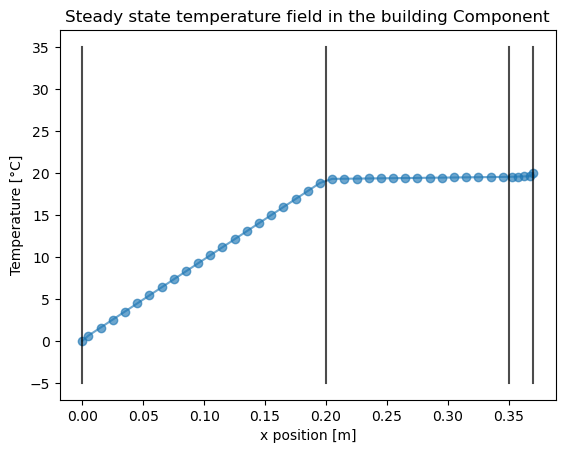

In [12]:
plt.xlabel("x position [m]")
plt.ylabel("Temperature [°C]")
plt.plot(x_pos, T_plus, 'o-', alpha=0.65)
x_w=0
for layer in layers:
    plt.plot([x_w,x_w], [-5,35], color='k', alpha=0.7)
    x_w += layer.width
plt.plot([layer.width_sum,layer.width_sum], [-5,35], color='k', alpha=0.7)
plt.title("Steady state temperature field in the building Component")
a = np.array([1,-1,3])

### Determine the time in hours when a 3-layered component reaches the steady state

In [13]:
print("time until steady state: " + str(round(t/60/60,1)) + " h")

time until steady state: 473.7 h
